In [1]:
import os
import umap
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer, util

In [2]:
#df_en_path = os.path.join("data","en_quora_questions.csv")
df_en_path = os.path.join("data","en_ag_news.csv")
df_ar_path = os.path.join("data", "arabic_categorization_data.csv")
embedding_en_path = os.path.join("quora_questions_embeddiong.pkl")
embedding_ar_path = os.path.join("arabic_embeddiong.pkl")

In [3]:
SIZE = 10000

df_en = pd.read_csv(df_en_path).sample(SIZE)
df_ar = pd.read_csv(df_ar_path)


with open(embedding_en_path, "rb") as fp:
    en_embedding = pickle.load(fp)
    
with open(embedding_ar_path, "rb") as fp:
    ar_embedding = pickle.load(fp)
    

In [25]:
df_en

,Class Index,Title,text
8096,1,Anti-Gay Marriage Amendment Off Ballot (AP),AP - A proposed constitutional amendment to ba...
91788,2,Injury joins insult for winless NBA Hornets (AFP),AFP - Two-time All-Star guard Baron Davis will...
104027,2,Giants are now playing for next year,"When Tom Coughlin growled, gritted his teeth a..."
76359,2,Sports: Indians reach terms with Elarton,CLEVELAND Pitcher Scott Elarton has agreed to ...
82982,1,Band of brothers vow to survive,"DODGING rockets, bullets and bomb blasts in th..."
...,...,...,...
50520,2,Anderson Hoping for Happier Times for Scotland,Russell Anderson claims he relishes every oppo...
20554,4,Frances Damages NASA Space Center (AP),AP - Hurricane Frances did more damage to the ...
81945,4,432-Year Search: Lost Star Found (SPACE.com),SPACE.com - Danish astronomer Tycho Brahe spot...
42839,4,SWsoft teams with Acronis to boost virtual ser...,"Firms sign joint development, marketing deal f..."


In [4]:
df_en.rename(columns={"Description":"text"}, inplace=True)

In [5]:
df_en.rename(columns={"question_text": "text"}, inplace=True)

In [6]:
embedder_en = SentenceTransformer('distilroberta-base-msmarco-v1')
embedder_en.cuda()

SentenceTransformer(
  (0): Transformer(
    (auto_model): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50267, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_features=768, 

In [7]:
multilingual_model = SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
multilingual_model.cuda()

SentenceTransformer(
  (0): Transformer(
    (auto_model): XLMRobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(250002, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_features=7

In [8]:
queries_en = df_en["text"].sample(5).tolist()
queries_ar = df_ar["text"].sample(5).tolist()

In [9]:
text_en_list = list(df_en["text"].values)
res = embedder_en.encode(text_en_list, show_progress_bar=True, convert_to_numpy=True)

In [10]:
en_embedding = res

In [11]:
def get_closest_sentences(queries, df, embeddings, embedder, top_k=5):
    # Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
    for query in queries:
        query_embedding = embedder.encode(query, convert_to_tensor=True).detach().cpu()
        cos_scores = util.pytorch_cos_sim(query_embedding, embeddings)[0]
        cos_scores = cos_scores.cpu()

        #We use torch.topk to find the highest 5 scores
        top_results = torch.topk(cos_scores, k=top_k)

        print("\n\n======================\n\n")
        print("Query:", query)
        print("\nTop 5 most similar sentences in corpus:")

        
        for i, (score, idx) in enumerate(zip(top_results[0], top_results[1])):
            if i == 0:
                continue
            print(df["text"].iloc[int(idx)], "(Score: %.4f)" % (score))

In [12]:
get_closest_sentences(
    queries=queries_en,
    df=df_en,
    embeddings=en_embedding,
    embedder=embedder_en,
    top_k=5
)





Query: Circuit City Stores Inc., the No. 2 US electronics chain, said its second-quarter loss narrowed to \$11.9 million as the company sold more plasma-screen televisions and benefited from the acquisition of a Canadian retailer.

Top 5 most similar sentences in corpus:
Circuit City Stores Inc., the nation #39;s No. 2 electronics retailer, reported Monday that same-store sales declined 4.3 percent in the third quarter, largely because of weak sales of music and movie software. (Score: 0.9189)
Circuit City Stores posted a narrower quarterly loss from continuing operations on Friday but said the outlook was cautious for the current quarter, which includes the key holiday season. (Score: 0.8694)
AP - Circuit City Stores Inc., the nation's No. 2 electronics retailer, reported Monday that same-store sales declined 4.3 percent in the third quarter, largely because of weak sales of music and movie software. (Score: 0.8393)
Circuit City (NYSE: CC), like its rival Best Buy (NYSE: BBY), pre

In [13]:
get_closest_sentences(
    queries=queries_ar,
    df=df_ar,
    embeddings=ar_embedding,
    embedder=multilingual_model,
    top_k=5
)





Query: 
أمكن للوحدات الأمنية التابعة للفرقة الجهوية للشّرطة البلديّة بتونس بالتّنسيق مع منطقة الأمن الوطني بسيدي حسين، من حجز حوالي 750 كغ من اللّحوم لعدم صلوحيّتها للاستهلاك بمستودع داخل ضيعة فلاحية بسيدي حسين من ولاية تونس.
وباستشارة النيابة العمومية، تمّ الاحتفاظ بصاحب المحل وحجز الكميّة المذكورة، بحسب ما أفادت به وزارة الداخلية في بلاغ لها.


Top 5 most similar sentences in corpus:

تمكنت وحدات الحرس الديواني والتفتيشات بوادي الربايع من معتمدية بن قردان، ظهر اليوم الجمعة، من حجز أكثر من 50 كيلوغراما من مادة القنب الهندي أو ما يعرف بالزطلة مخبأة داخل هيكل سيارة مواطن ليبي قادم من تونس بإتجاه القطر الليبي وفق ما صرح به مصدر ديواني لمراسلة الجوهرة أف أم بالجهة .
هذا وتمت احالة الليبي على التحقيق بإذن من النيابة العمومية فيما لاتزال العناصر الديوانية بصدد احتساب الكمية قبل إحالتها على المصالح المختصة .
 (Score: 0.7336)

أفادت مراسلة "الجوهرة أف أم" بالوطن القبلي بأن أعوان الإدارة الجهوية للتجارة بنابل تمكنوا من حجز 1752 علبة معجون طماطم و1080 علبة معجون هرسية غير صالحة للاستهلاك كا

In [27]:
K = 4
categories = df_en["Class Index"].astype("category")
labels = categories.cat.codes

In [15]:
# todo cluster news data

kmeans_obj = KMeans(n_clusters=K, n_jobs=6)

In [16]:
clustering_labels = kmeans_obj.fit_predict(en_embedding)

/home/erez/PycharmProjects/ds_sentence_bert/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [17]:
clustering_labels

array([2, 1, 1, ..., 2, 0, 0], dtype=int32)

In [36]:
# noisy_ar_embedding = ar_embedding + np.random.rand(1)*np.ones_like(ar_embedding)

reducer = umap.UMAP(2)
low_dim_en_data = reducer.fit_transform(en_embedding, labels)

/home/erez/PycharmProjects/ds_sentence_bert/venv/lib/python3.8/site-packages/umap/spectral.py:252: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/erez/PycharmProjects/ds_sentence_bert/venv/lib/python3.8/site-packages/umap/spectral.py:252: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


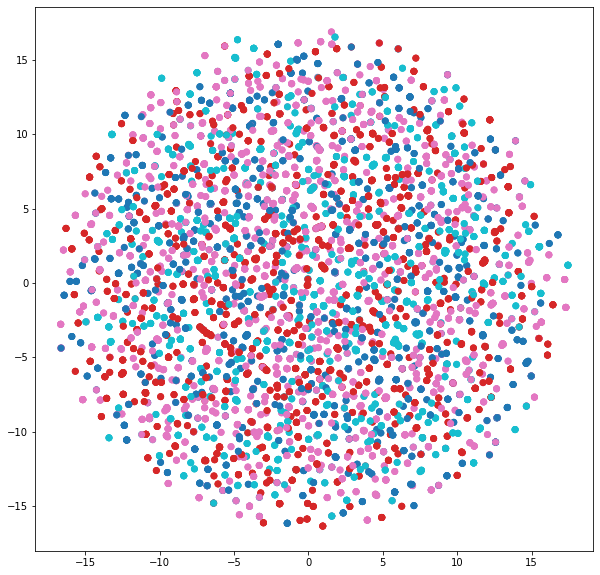

In [37]:
plt.figure(figsize=(10,10))
plt.scatter(low_dim_en_data[:,0], low_dim_en_data[:,1], c=clustering_labels, cmap="tab10")
plt.show()

In [20]:
low_dim_ar_data

NameError: name 'low_dim_ar_data' is not defined

In [22]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [33]:
adjusted_rand_score(labels, clustering_labels)

0.5705153850357068

In [24]:
silhouette_score(en_embedding, clustering_labels)

0.051092833